## Datasets path

In [1]:
input_path = './merged_descriptions.jsonl'  # à adapter
output_path = './clusters_descriptions.jsonl'

# Import

In [2]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import hdbscan
from collections import Counter
import umap
import matplotlib.pyplot as plt
import numpy as np

2025-10-19 11:00:29.365259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset

In [3]:

data = []
with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print("view of the dataset :")
print(df.head())

view of the dataset :
  id                                       descriptions
0  0  [This is a shell script (.sh) named extract_wi...
1  1  [This is a shell script (.sh) named script_to_...
2  2  [This is a shell script (.sh) named corrected_...
3  3  [This is a log file (.log) named window_change...
4  4  [This is a shell script (.sh) named monitor_vs...


## Prepare the data

In [4]:
descriptions = [d[0] if isinstance(d, list) else d for d in df['descriptions'].tolist()]

# Load the model

In [5]:

model = SentenceTransformer("all-MiniLM-L6-v2")

## Generate the embeddings with Sentence Transformer

In [6]:
embeddings = model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

## Embeddings normalization

In [7]:

embeddings_norm = normalize(embeddings)

## Clustering with HDBSCAN

In [8]:

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,  # à ajuster selon ton dataset
    metric='euclidean',  # ou 'cosine' si tu préfères
    cluster_selection_method='eom'
)

labels = clusterer.fit_predict(embeddings_norm)
df['cluster'] = labels
print("Clusters repartition :")
print(Counter(labels))

/home/aidan/miniconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aidan/miniconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters repartition :
Counter({-1: 451, 7: 346, 5: 277, 12: 211, 17: 139, 3: 122, 19: 117, 13: 97, 18: 95, 15: 70, 14: 50, 4: 48, 10: 33, 16: 32, 9: 9, 11: 7, 0: 7, 2: 6, 6: 6, 1: 6, 8: 5})


## VIsualisation clusters with UMAP

/home/aidan/miniconda3/envs/MLproject/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_17194/1757997730.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


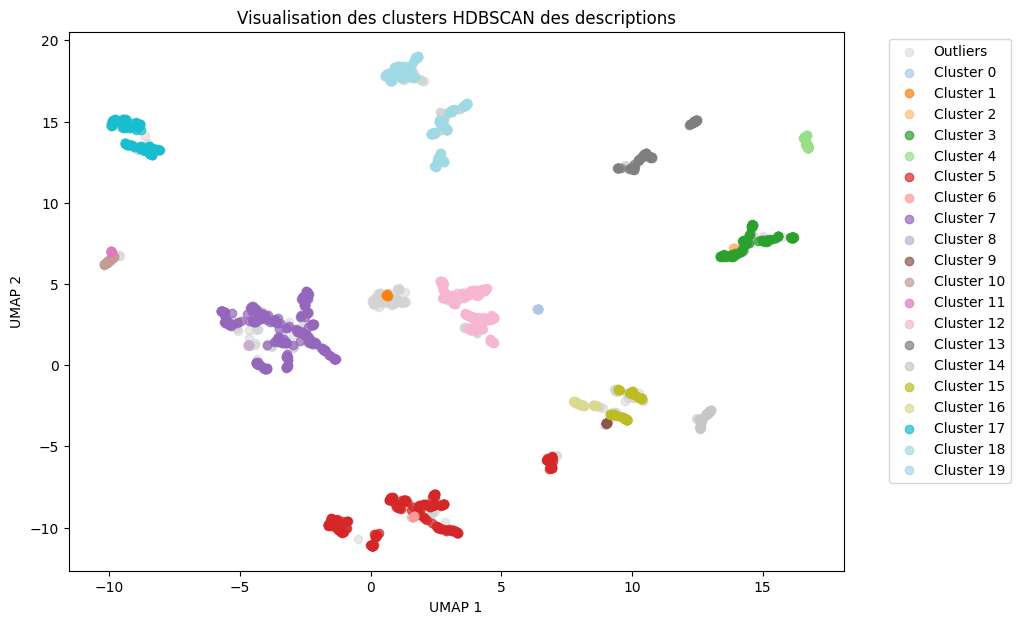

In [9]:
# Réduction à 2D
reducer = umap.UMAP(n_components=2, random_state=42)
emb_2d = reducer.fit_transform(embeddings_norm)

# Graphe
plt.figure(figsize=(10, 7))
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = labels == label
    if label == -1:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='lightgray', label='Outliers', alpha=0.5)
    else:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c=[colors(i)], label=f'Cluster {label}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Visualisation des clusters HDBSCAN des descriptions")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

## Group the descriptions by clusters

In [11]:
clusters = df[df['cluster'] != -1].groupby('cluster')['descriptions'].apply(list)

## Prepare the output file

In [12]:
with open(output_path, 'w', encoding='utf-8') as f_out:
    for c, descs in clusters.items():
        json.dump({
            "cluster": int(c),
            "descriptions": descs
        }, f_out, ensure_ascii=False)
        f_out.write("\n")

print(f"Fichier JSONL de clusters généré : {output_path}")

Fichier JSONL de clusters généré : ./clusters_descriptions.jsonl
